## Imports requisite libraries

In [1]:
#!/usr/bin/env python3

# Copyright (c) 2020 NVIDIA Corporation. All rights reserved.
# This work is licensed under the NVIDIA Source Code License - Non-commercial. Full
# text can be found in LICENSE.md

"""Test a PoseCNN on images"""

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
from torch.utils.data import DataLoader, Dataset

import argparse
import pprint
import time, os, sys
import os.path as osp
import numpy as np
import cv2
import scipy.io
import glob
import json
import h5py
import matplotlib.pyplot as plt
from imageio import imread
from configparser import Interpolation

import _init_paths
from fcn.test_dataset import clustering_features, crop_rois, match_label_crop
from fcn.test_common import _vis_minibatch_segmentation, _vis_features, _vis_minibatch_segmentation_final
from fcn.config import cfg, cfg_from_file, get_output_dir
import networks
from utils.blob import pad_im
from utils import mask as util_
from utils.evaluation import multilabel_metrics

## Initializes the network with relevant parameters

In [3]:
# This dictionary contains all of the relevant arguments for the script
args = {'gpu_id':0, 'pretrained':None, 'pretrained_crop':None, 'cfg_file':None, 'dataset_name':'shapenet_scene_train', 'depth_name':'*depth.png', 'color_name':'*color.png', 'imgdir':None, 'randomize':False, 'network_name':None, 'image_path':None}
dir = '../'

# Change to reflect location of your data and networks
args['imgdir'] = dir + 'data/demo'
args['network_name'] = 'seg_resnet34_8s_embedding'

# Choose which checkpoint to load
args['pretrained'] = dir + 'data/checkpoints/trained_augmented_checkpoint.pth'

args['pretrained_crop'] = dir + 'data/checkpoints/seg_resnet34_8s_embedding_cosine_rgbd_add_crop_sampling_epoch_16.checkpoint.pth'
args['cfg_file'] = dir + 'experiments/cfgs/seg_resnet34_8s_embedding_cosine_rgbd_add_tabletop.yml'

# Finds the matching config file
if args['cfg_file'] is not None:
    cfg_from_file(args['cfg_file'])
if len(cfg.TEST.CLASSES) == 0:
    cfg.TEST.CLASSES = cfg.TRAIN.CLASSES

# Randomizes the seed
if not args['randomize']:
    # fix the random seeds (numpy and caffe) for reproducibility
    np.random.seed(cfg.RNG_SEED)

# Locates the device
cfg.gpu_id = 0
cfg.device = torch.device('cuda:{:d}'.format(cfg['gpu_id']))
cfg.instance_id = 0
num_classes = 2
cfg.MODE = 'TEST'

# Loads the network for the initial embedding
network_data = torch.load(args['pretrained'])
network = networks.__dict__[args['network_name']](num_classes, cfg.TRAIN.NUM_UNITS, network_data).cuda(device=cfg.device)
network = torch.nn.DataParallel(network, device_ids=[cfg.gpu_id]).cuda(device=cfg.device)
cudnn.benchmark = True
network.eval()

# Loads the refinement network
network_data_crop = torch.load(args['pretrained_crop'])
network_crop = networks.__dict__[args['network_name']](num_classes, cfg.TRAIN.NUM_UNITS, network_data_crop).cuda(device=cfg.device)
network_crop = torch.nn.DataParallel(network_crop, device_ids=[cfg.gpu_id]).cuda(device=cfg.device)
network_crop.eval()

model keys
conv1.weight
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn1.running_mean
layer1.0.bn1.running_var
layer1.0.bn1.num_batches_tracked
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.bn2.running_mean
layer1.0.bn2.running_var
layer1.0.bn2.num_batches_tracked
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn1.running_mean
layer1.1.bn1.running_var
layer1.1.bn1.num_batches_tracked
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.bn2.running_mean
layer1.1.bn2.running_var
layer1.1.bn2.num_batches_tracked
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.bn1.running_mean
layer1.2.bn1.running_var
layer1.2.bn1.num_batches_tracked
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.bn2.running_mean
layer1.2.bn2.running_var
layer1.2.bn2.num_batches_tracked
layer2.0.conv1.weight
layer2.0.bn1.

DataParallel(
  (module): SEGNET(
    (embedding_loss): EmbeddingLoss()
    (fcn): Resnet34_8s(
      (resnet34_8s): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (conv1): Conv2

## Helper functions for processing data and benchmarking

In [21]:
# Turns depth image into a point cloud
def xyz_from_depth(depth_img, intrinsic):
        fx = intrinsic[0][0]
        fy = intrinsic[1][1]
        px = intrinsic[0][2]
        py = intrinsic[1][2]
        height, width = depth_img.shape

        indices = np.indices((height, width), dtype=np.float32).transpose(1,2,0)
        z_e = depth_img
        x_e = (indices[..., 1] - px) * z_e / fx
        y_e = (indices[..., 0] - py) * z_e / fy
        xyz_img = np.stack([x_e, y_e, z_e], axis=-1) # Shape: [H x W x 3]
        return xyz_img

# Turns raw inputs into a sample to apply to the network
def format_inputs(color, depth, intrinsic, crop_bounds=None, resize=False, scale=True, make_patch=False, scale_factor=None):
    """
    color: H x W x C Numpy Array in RGB format
    depth: H x W Numpy Array
    intrinsic: 3 x 3 intrinsic matrix
    crop_bounds: Tuple of (x_min, x_max, y_min, y_max) bounds for cropping the image
    resize: Boolean flag for whether to resize the image to the demo image size
    scale: Scales the input down by a factor of 1000 (for all data except for 5k)
    make_patch: Boolean flag for whether to make a patch of the image in a larger empty tensor
    scale_factor: The factor by which to scale the image (defaults to 1.0)

    Returns: dictionary sample with keys: 'image_color', 'depth' formatted for network input
    """
    # Crops and resizes the color image
    if crop_bounds:
        color = color[crop_bounds[0]:crop_bounds[1], crop_bounds[2]:crop_bounds[3],...]
    if resize:
        color = cv2.resize(color, (640, 480), interpolation=cv2.INTER_LINEAR)
    if scale_factor != None:
        color = cv2.resize(color, (int((color.shape[1] * scale_factor)), int((color.shape[0] * scale_factor))), interpolation=cv2.INTER_LINEAR)
    if make_patch:
        tmp = color.copy()
        color = np.zeros(shape=(480, 640, 3), dtype=np.uint8)
        color[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 0] = tmp[:,:,0]
        color[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 1] = tmp[:,:,1]
        color[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 2] = tmp[:,:,2]
    
    # Adds the RGB image to the sample
    plt.imshow(color)
    print(color.shape)
    color = cv2.cvtColor(color, cv2.COLOR_RGB2BGR)
    color_tensor = torch.from_numpy(color.copy()) / 255.0
    pixel_mean = torch.tensor(cfg.PIXEL_MEANS / 255.0).float()
    color_tensor -= pixel_mean
    color_blob = color_tensor.permute(2, 0, 1)
    sample = {'image_color': color_blob.unsqueeze(0)}

    # Converts the depth image to a point cloud
    depth = depth.astype(np.float32)
    if scale:
        depth /= 1000.0
    height = depth.shape[0]
    width = depth.shape[1]
    xyz = xyz_from_depth(depth, intrinsic)

    # Crops and resizes the point cloud
    if crop_bounds:
        xyz = xyz[crop_bounds[0]:crop_bounds[1], crop_bounds[2]:crop_bounds[3],...]
    if resize:
        xyz = cv2.resize(xyz, (640, 480), interpolation=cv2.INTER_LINEAR)
    if scale_factor != None:
        xyz = cv2.resize(xyz, (int((xyz.shape[1] * scale_factor)), int((xyz.shape[0] * scale_factor))), interpolation=cv2.INTER_LINEAR)
    if make_patch:
        m = xyz[...,2][10,10]
        tmp = xyz.copy()
        print(type(tmp[0][0][0]))
        xyz = np.zeros(shape=(480, 640, 3), dtype=np.float32) + m.astype(np.float32)
        print(type(xyz[0][0][0]))
        xyz[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 0] = tmp[:,:,0]
        xyz[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 1] = tmp[:,:,1]
        xyz[100:(100 + tmp.shape[0]), 100:(100 + tmp.shape[1]), 2] = tmp[:,:,2]

    # Adds the point cloud to the sample
    depth_blob = torch.from_numpy(xyz).permute(2, 0, 1)
    sample['depth'] = depth_blob.unsqueeze(0)

    return sample

# Runs k-means on the point cloud
def kmeans(X, K=10, Niter=10, metric='euclidean'):
    X = X[0].permute(1,2,0).reshape(X.shape[2] * X.shape[3], X.shape[1])
    N, D = X.shape
    C = X[:K, :].clone() # Initialize the centroids
    if metric == 'euclidean':
        x_i = X.view(N, 1, D)
        c_j = C.view(1, K, D)
    elif metric == 'cosine':
        x_i = X
        c_j = C

    for i in range(Niter):
        # E step
        if metric == 'euclidean':
            D_ij = ((x_i - c_j) ** 2).sum(-1)
            print(f"shape is: {D_ij.shape}")
        elif metric == 'cosine':
            D_ij = 0.5 * (1 - torch.mm(x_i, c_j.T))

        cl = D_ij.argmin(dim=1).long().view(-1)

        # M step
        C.zero_()
        C.scatter_add_(0, cl[:, None].repeat(1, D), X)

        Ncl = torch.bincount(cl, minlength=K).type_as(C).view(K, 1)
        C /= Ncl

    return cl, C

# Tests a sample on the network and visualizes the result
def test_sample(sample, network, network_crop, l=None, mode='clustering_features'):

    # construct input
    image = sample['image_color'].cuda()
    if cfg.INPUT == 'DEPTH' or cfg.INPUT == 'RGBD':
        depth = sample['depth'].cuda()
    else:
        depth = None

    if 'label' in sample:
        label = sample['label'].cuda()
    else:
        label = None

    # run network
    features = network(image, label, depth).detach()

    if mode == 'clustering_features':
        out_label, selected_pixels = clustering_features(features, num_seeds=100)
    elif mode == 'kmeans':
        # Number of labels for kmeans
        K = torch.max(label[0]).item() + 1
        cluster_labels, C = kmeans(features, K=K, metric='cosine')

        # Assigns the largest label to the background
        count = torch.zeros(K, dtype=torch.long)
        for i in range(K):
            count[i] = (cluster_labels == i).sum()
        label_max = torch.argmax(count)
        if label_max != 0:
            index1 = cluster_labels == 0
            index2 = cluster_labels == label_max
            cluster_labels[index1] = label_max
            cluster_labels[index2] = 0

        out_label = torch.reshape(cluster_labels, shape=(image.shape[2], image.shape[3])).cpu()
    else:
        print('Invalid mode: try clustering_features or kmeans')
        return

    # zoom in refinement
    out_label_refined = None
    if network_crop is not None:
        rgb_crop, out_label_crop, rois, depth_crop = crop_rois(image, out_label.clone(), depth)
        if rgb_crop.shape[0] > 0:
            features_crop = network_crop(rgb_crop, out_label_crop, depth_crop)
            labels_crop, selected_pixels_crop = clustering_features(features_crop)
            out_label_refined, labels_crop = match_label_crop(out_label, labels_crop.cuda(), out_label_crop, rois, depth_crop)
        else:
            out_label_refined = out_label

    if cfg.TEST.VISUALIZE:
        bbox = None
        _vis_minibatch_segmentation_final(image, depth, label, out_label, out_label_refined, features, 
            selected_pixels=selected_pixels, bbox=bbox)
    return out_label, out_label_refined

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __repr__(self):
        return '{:.3f} ({:.3f})'.format(self.val, self.avg)

# test a dataset (for calculating metrics)
def test_segnet(test_loader, network, output_dir, network_crop):

    batch_time = AverageMeter()
    epoch_size = len(test_loader)

    # switch to test mode
    network.eval()
    if network_crop is not None:
        network_crop.eval()

    metrics_all = []
    iou = np.array([])
    iou_refined = np.array([])
    metrics_all_refined = []
    for i, sample in enumerate(test_loader):
        end = time.time()

        # Only counts the first 1000 images
        if i > 1000:
            break

        # construct input
        image = sample['image_color'].cuda()
        if cfg.INPUT == 'DEPTH' or cfg.INPUT == 'RGBD':
            depth = sample['depth'].cuda()
        else:
            depth = None
        label = sample['label'].cuda()

        # run network
        features = network(image, label, depth).detach()
        out_label, selected_pixels = clustering_features(features, num_seeds=100)

        # evaluation
        gt = sample['label'].squeeze().numpy()
        prediction = out_label.squeeze().detach().cpu().numpy()
        metrics = multilabel_metrics(prediction, gt)
        metrics_all.append(metrics)

        gt_count = np.max(gt).astype(int)
        pred_count = np.max(prediction).astype(int)

        iou_now = np.zeros(shape=(gt_count, pred_count))

        for v in range(1, gt_count + 1):
            for w in range(1, pred_count + 1):
                iou_now[v - 1][w - 1] = np.sum(np.logical_and(gt == v, prediction == w)) / np.sum(np.logical_or(gt == v, prediction == w))
        
        # Find the mask that best fits the ground truth
        if gt_count > 0 and pred_count > 0:
            iou_now = np.max(iou_now, axis = 1)
            iou = np.append(iou, iou_now)

        # zoom in refinement
        out_label_refined = None
        if network_crop is not None:
            rgb_crop, out_label_crop, rois, depth_crop = crop_rois(image, out_label.clone(), depth)
            if rgb_crop.shape[0] > 0:
                features_crop = network_crop(rgb_crop, out_label_crop, depth_crop)
                labels_crop, selected_pixels_crop = clustering_features(features_crop)
                out_label_refined, labels_crop = match_label_crop(out_label, labels_crop.cuda(), out_label_crop, rois, depth_crop)

        # evaluation
        if out_label_refined is not None:
            prediction_refined = out_label_refined.squeeze().detach().cpu().numpy()
        else:
            prediction_refined = prediction.copy()
        metrics_refined = multilabel_metrics(prediction_refined, gt)
        metrics_all_refined.append(metrics_refined)

        pred_count = np.max(prediction_refined).astype(int)
        iou_now = np.zeros(shape=(gt_count, pred_count))

        for v in range(1, gt_count + 1):
            for w in range(1, pred_count + 1):
                iou_now[v - 1][w - 1] = np.sum(np.logical_and(gt == v, prediction == w)) / np.sum(np.logical_or(gt == v, prediction == w))
        
        # Find the mask that best fits the ground truth
        if gt_count > 0 and pred_count > 0:
            iou_now = np.max(iou_now, axis = 1)     
            iou_refined = np.append(iou_refined, iou_now)

        # measure elapsed time
        batch_time.update(time.time() - end)
        # print('[%d/%d], batch time %.2f' % (i, epoch_size, batch_time.val))
        if i % 100 == 0:
            print(i)

    # sum the values with same keys
    print('========================================================')
    result = {}
    num = len(metrics_all)
    print('%d images' % num)
    print('========================================================')
    for metrics in metrics_all:
        for k in metrics.keys():
            result[k] = result.get(k, 0) + metrics[k]

    for k in sorted(result.keys()):
        result[k] /= num
        print('%s: %f' % (k, result[k]))

    print('%.6f' % (result['Objects Precision']))
    print('%.6f' % (result['Objects Recall']))
    print('%.6f' % (result['Objects F-measure']))
    print('%.6f' % (result['Boundary Precision']))
    print('%.6f' % (result['Boundary Recall']))
    print('%.6f' % (result['Boundary F-measure']))
    print('%.6f' % (result['obj_detected_075_percentage']))
    print(f"IoU: {iou.mean()}")
    print(f"IoU maximum: {iou.max()}")
    print(f"IoU minimum: {iou.min()}")

    print('========================================================')
    print(result)
    print('====================Refined=============================')

    result_refined = {}
    for metrics in metrics_all_refined:
        for k in metrics.keys():
            result_refined[k] = result_refined.get(k, 0) + metrics[k]

    for k in sorted(result_refined.keys()):
        result_refined[k] /= num
        print('%s: %f' % (k, result_refined[k]))
    print(result_refined)

    print(f"IoU refined: {iou_refined.mean()}")
    print(f"IoU refined maximum: {iou_refined.max()}")
    print(f"IoU refined minimum: {iou_refined.min()}")
    print('========================================================')

In [22]:
# Dataloader for synthetic dataset (e.g. 5k)
class binDataset(Dataset):
    def __init__(self, file, for_training=False):
        # Loads the data from the h5 file, where file is the path to the .h5 file
        self.file = h5py.File(file, 'r')
        self.len = self.file['frame0_data'].shape[0]
        self.name = '5k dataset'
        self.num_classes = 2
        self.for_training = for_training
    
    def __len__(self):
        return self.len

    # Computes point cloud from depth image and camera intrinsics
    def compute_xyz(self, depth_img, intrinsic):
        fx = intrinsic[0][0]
        fy = intrinsic[1][1]
        px = intrinsic[0][2]
        py = intrinsic[1][2]
        height, width = depth_img.shape

        indices = np.indices((height, width), dtype=np.float32).transpose(1,2,0)
        z_e = depth_img
        x_e = (indices[..., 1] - px) * z_e / fx
        y_e = (indices[..., 0] - py) * z_e / fy
        xyz_img = np.stack([x_e, y_e, z_e], axis=-1) # Shape: [H x W x 3]
        return xyz_img
    
    def __getitem__(self, index):
        # Checks whether to grab from frame 0 or 1
        # if index > self.file['frame0_data'].shape[0]:
        #     index = index - self.file['frame0_data'].shape[0]
        #     cat = 'frame1_'
        # else:
        #     cat = 'frame0_'
        cat = 'frame0_'

        # Loads the color image
        rgb = self.file[cat + 'data'][index][...,0:3]
        rgb = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        im_tensor = torch.from_numpy(rgb) / 255.0
        pixel_mean = torch.tensor(cfg.PIXEL_MEANS / 255.0).float()
        im_tensor -= pixel_mean
        image_blob = im_tensor.permute(2, 0, 1)
        if self.for_training:
            sample = {'image_color': image_blob}
        else:
            sample = {'image_color': image_blob.unsqueeze(0)}

        # Loads the depth image and camera intrinsics
        depth = self.file[cat + 'depth'][index]
        depth[depth < -1000] = 0
        intrinsic = json.loads(self.file[cat + 'metadata'][index])['camera']['intrinsic_matrix']
        xyz = self.compute_xyz(depth, intrinsic).astype(np.float32)
        depth_blob = torch.from_numpy(xyz).permute(2, 0, 1)
        if self.for_training:
            sample['depth'] = depth_blob
        else:
            sample['depth'] = depth_blob.unsqueeze(0)

        # Loads the label masks
        label = self.file[cat + 'mask'][index]
        label = (label + 1) % 65536
        label %= np.max(label)
        label = label.reshape(1, label.shape[0], label.shape[1])
        label_blob = torch.from_numpy(label)
        if self.for_training:
            sample['label'] = label_blob
        else:
            sample['label'] = label_blob.unsqueeze(0)

        return sample

## Your code here

Data sample must be in the form of a dictionary with keys 'image_color', an 1x3xHxW normalized tensor, 'depth', a 1x3xHxW point cloud tensor, and (optionally) 'label', a 1xHxW ground truth label.

Example: Bin data. Here is the general pipeline:

/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3062: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


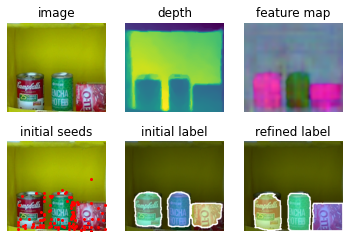

In [25]:
crop = True
gt_labels = [3,3,3,2,1,1,1,3,3,3,3,2,1,1,1,1,1,1,1,1,3,3,3,4,4,4,4,4,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,4,5,5,5]

# Loads the data from the h5 file, where file is the path to the .h5 file
file_name = '../data/demo/image_data.npy'
data = np.load(file_name, allow_pickle=True).item()

# Formats the data for the network
rgb_list = data['frame0_rgb']
H, W = rgb_list[0].shape[:2]
N = len(rgb_list)
depth_list = data['frame0_depth']
rgb = np.zeros((N, H, W, 3)).astype(np.uint8)
depth = np.zeros(shape=(N, H, W))
info = data['frame0_info']
intrinsics = np.zeros(shape=(N, 3, 3))
for i in range(N):
    intrinsics[i] = np.array(info[i]['K']).reshape(3, 3)
    depth[i] = depth_list[i]
    rgb[i] = cv2.cvtColor(rgb_list[i], cv2.COLOR_RGB2BGR)

xyz = np.zeros(shape=(N, H, W, 3))
for i in range(len(depth)):
    xyz[i] = xyz_from_depth(depth[i], intrinsics[i]).astype(np.float32)
bounds = [200,420,440,640]
if crop:
    rgb = rgb[:, bounds[0]:bounds[1], bounds[2]:bounds[3], :]
    xyz = xyz[:, bounds[0]:bounds[1], bounds[2]:bounds[3], :]
rgb = np.rot90(rgb, k=3, axes=(1,2))
xyz = np.rot90(xyz, k=3, axes=(1,2)) / 1000

# S = rgb.shape[0]
S = 1

# Runs the network on the data
for i in range(S):
    im_tensor = torch.from_numpy(rgb[i].copy()) / 255.0
    pixel_mean = torch.tensor(cfg.PIXEL_MEANS / 255.0).float()
    im_tensor -= pixel_mean
    image_blob = im_tensor.permute(2, 0, 1)
    sample = {'image_color': image_blob.unsqueeze(0)}

    depth_blob = torch.from_numpy(xyz[i].copy().astype(np.float32)).permute(2, 0, 1)
    sample['depth'] = depth_blob.unsqueeze(0)

    out_label, out_label_refined = test_sample(sample, network, network_crop, gt_labels[i])


A (better) example: 5k_prime dataset. 

/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3062: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


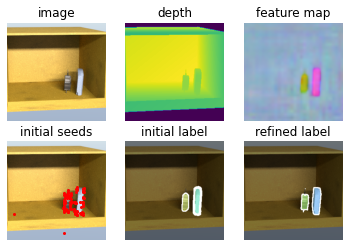

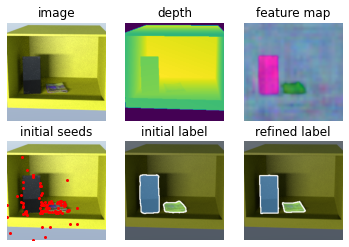

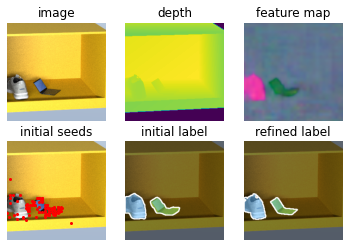

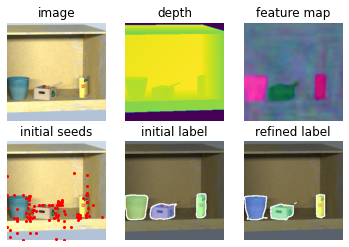

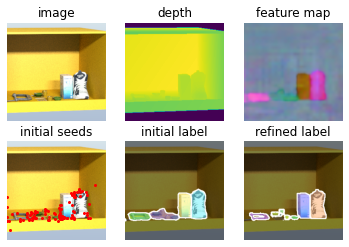

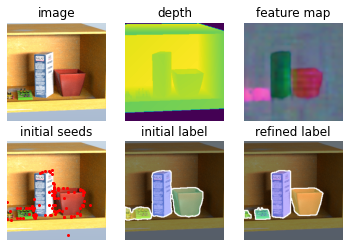

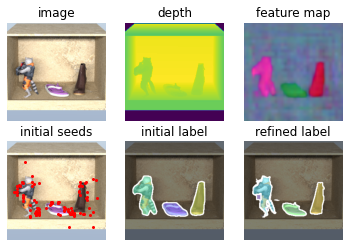

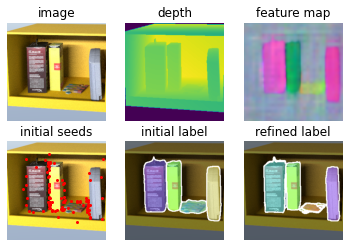

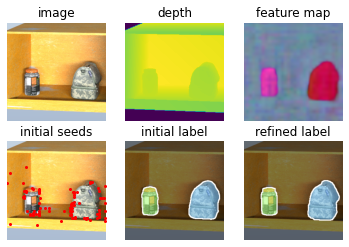

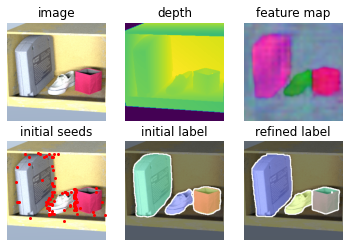

In [20]:
# Loads the data into the dataloader
file_name = "/home/thomas/Desktop/aurmr_perception-master/outputs/test_shard_000000_prime.h5"
dataset = binDataset(file_name)
sample_size = 10
# Runs the network on the data
for i in range(sample_size):
    item = dataset.__getitem__(i)
    out_label, out_label_refined = test_sample(item, network, network_crop)

## Evaluating the Network

Choose a dataset and use test_segnet to evaluate the network's performance on it.

In [16]:
file_name = "/home/thomas/Desktop/aurmr_perception-master/outputs/test_shard_000000_prime.h5"
dataset = binDataset(file_name)

test_segnet(dataset, network, './output', network_crop=network_crop)

/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3104: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/home/thomas/anaconda3/envs/uois3d/lib/python3.7/site-packages/torch/nn/functional.py:3062: UserWarning: nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_nearest is deprecated. Use nn.functional.interpolate instead.")


0
100
200
300
400
500
600
700
800
900
1000
1001 images
Boundary F-measure: 0.780437
Boundary Precision: 0.797086
Boundary Recall: 0.789251
Objects F-measure: 0.895416
Objects Precision: 0.884503
Objects Recall: 0.924062
obj_detected: 2.203796
obj_detected_075: 1.917083
obj_detected_075_percentage: 0.896087
obj_gt: 2.245754
0.884503
0.924062
0.895416
0.797086
0.789251
0.780437
0.896087
IoU: 0.8031704402817043
IoU maximum: 0.9846084200995926
IoU minimum: 0.0
{'Objects F-measure': 0.8954161891745592, 'Objects Precision': 0.8845029108014147, 'Objects Recall': 0.9240622832814472, 'Boundary F-measure': 0.7804372331620192, 'Boundary Precision': 0.7970862885394507, 'Boundary Recall': 0.7892510308420837, 'obj_detected': 2.203796203796204, 'obj_detected_075': 1.9170829170829171, 'obj_gt': 2.2457542457542456, 'obj_detected_075_percentage': 0.8960872460872453}
====================Refined=============================
Boundary F-measure: 0.817652
Boundary Precision: 0.812977
Boundary Recall: 0.85895